In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import load_data
import Zuschneiden
import Features
import get_classes
import cluster_representatives
import torch
import torch.nn as nn


# Calculate subsections
# matrix,static_features,kopfzeile=load_data.load_matrix(r"C:\Users\stroebel\Documents\Daten_SDMflex\AP/Pos_Cur_ohne_Lunker.csv")
matrix,static_features,kopfzeile=load_data.load_matrix(r"C:\Users\stroebel\Documents\Programme\CSV_SDMflex/SDMflex_V1_11_21.csv")
Schnitt = Zuschneiden.Sectioning(matrix,kopfzeile,G=1, c=True)
Zuschnitte = Features.region_feature(matrix,Schnitt,kopfzeile,static_features)

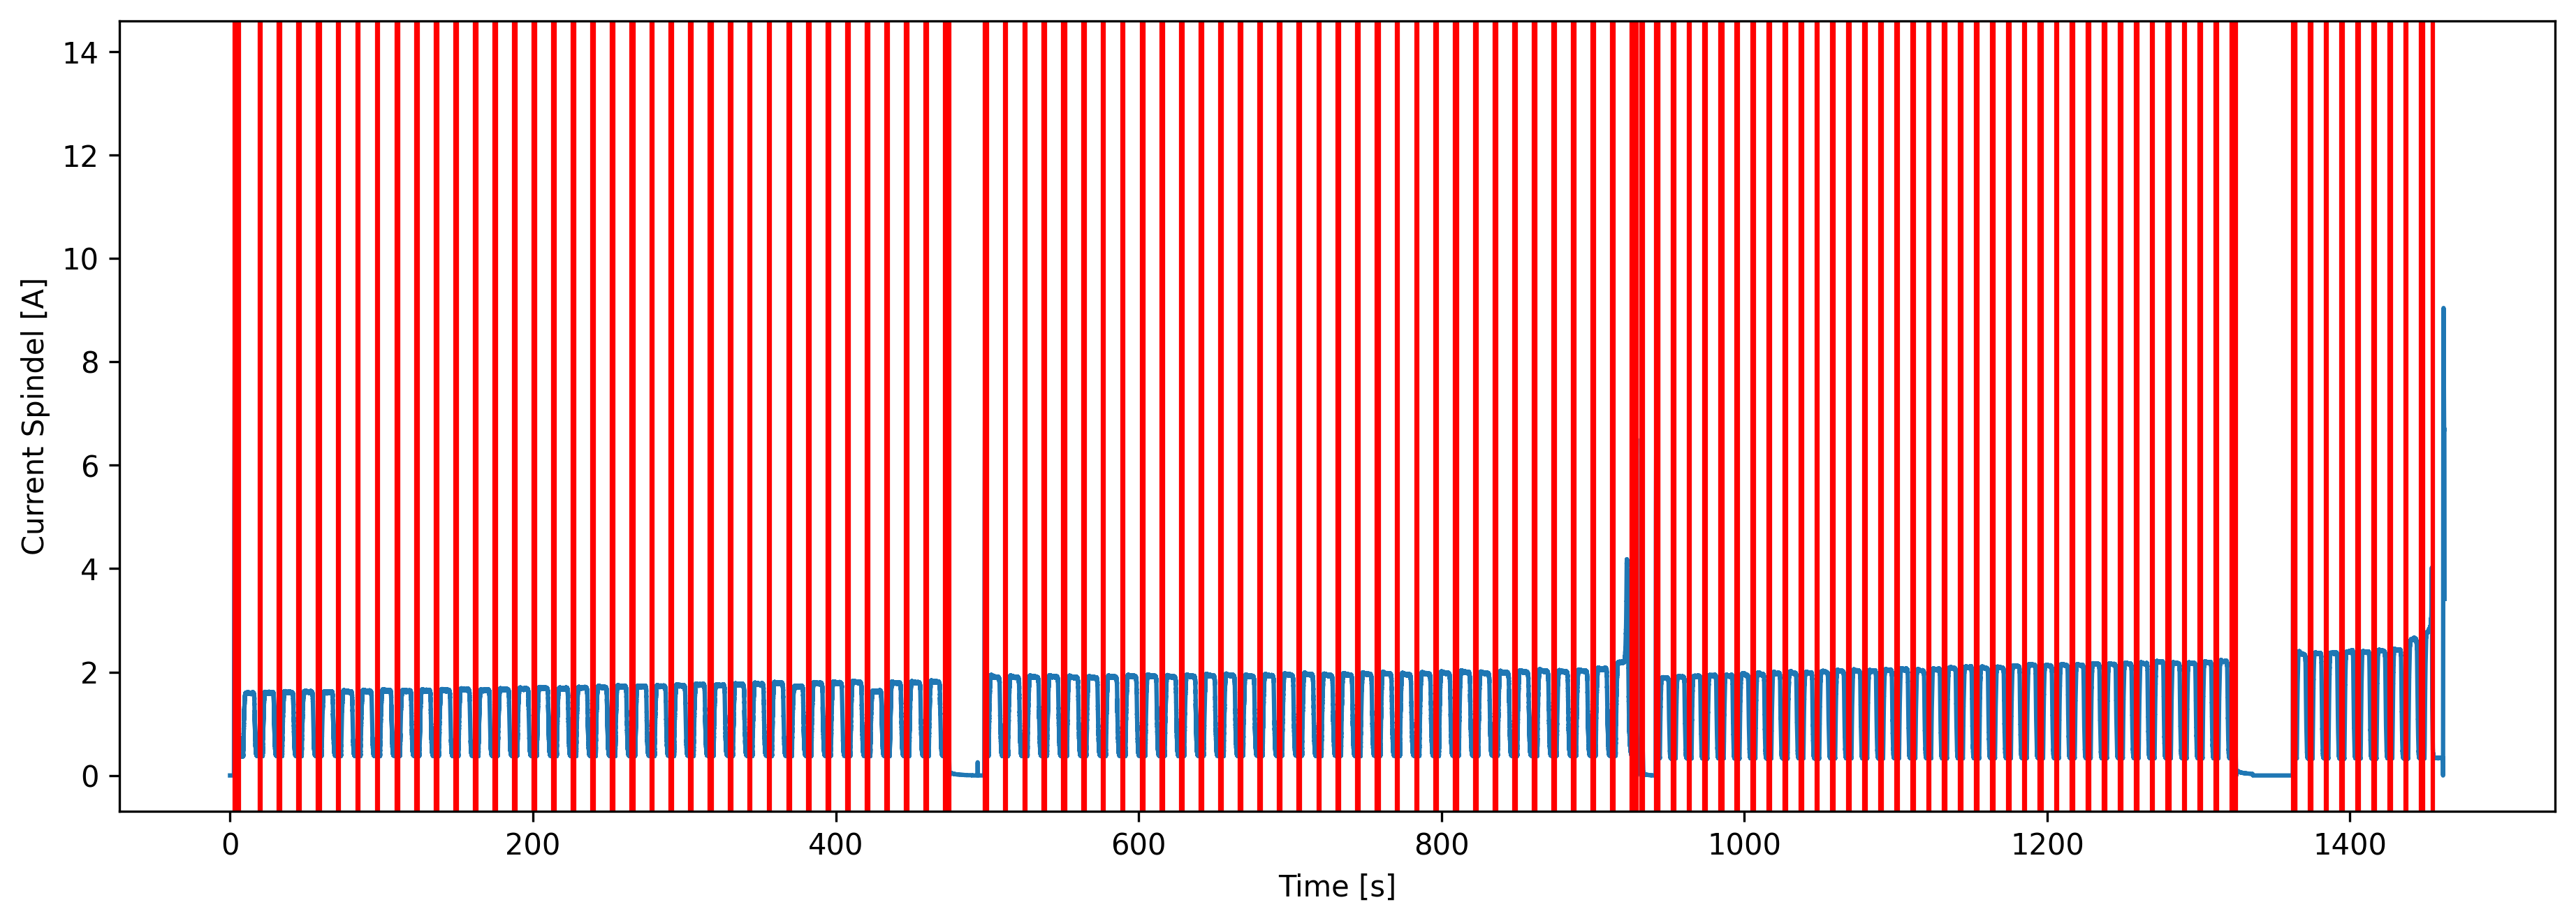

In [2]:
# Plot found segments
fig, ax = plt.subplots( figsize=(15, 5), dpi=300)
ax.plot(matrix[:,0],abs(matrix[:,kopfzeile.index('Cur_SP')]))
ax.set_ylabel('Current Spindel [A]')
ax.set_xlabel('Time [s]')

for i in range(len(Schnitt)):
    ax.axvline(x=Schnitt[i][0]*0.002, color='r',linestyle='-')
    ax.axvline(x=Schnitt[i][1]*0.002, color='r',linestyle='-')

# fig, ax = plt.subplots(2, figsize=(15, 5), dpi=300)
# print(kopfzeile)
# ax[0].plot(matrix[8000:18000,0],abs(matrix[8000:18000,kopfzeile.index('Cur_SP')]))
# ax[1].plot(matrix[8000:18000,0],abs(matrix[8000:18000,kopfzeile.index('Pos_Z')]))
# ax[0].set_ylabel('Current Spindel [A]')
# ax[1].set_ylabel('Z-Position [mm]')
# ax[1].set_xlabel('Time [s]')

# for i in [2]:#range(len(Schnitt)):
#     ax[0].axvline(x=Schnitt[i][0]*0.002, color='r',linestyle='-')
#     ax[0].axvline(x=Schnitt[i][1]*0.002, color='r',linestyle='-')
#     ax[1].axvline(x=Schnitt[i][0]*0.002, color='r',linestyle='-')
#     ax[1].axvline(x=Schnitt[i][1]*0.002, color='r',linestyle='-')
    
# fig.savefig(r'C:\Users\stroebel\Desktop\Cut.png')

In [3]:
# Calculate feature vector for segmentation
features=[]
for i in range(len(Zuschnitte)):
    # Used features are distance (x,y,z), average spindele speed and duration (spindlespeed is diveded by 6 due to recording)
    features += [(Zuschnitte[i][1][0], Zuschnitte[i][1][1],Zuschnitte[i][1][2], Zuschnitte[i][1][4]/6, Zuschnitte[i][1][5])]
features = np.array(features)

# Initial Segmentation
lables = get_classes.init_class(features)

# fig, ax = plt.subplots( figsize=(4, 4), dpi=300)
# ax.set_xlabel('feature 2 [mm]')
# ax.set_ylabel('feature 4 [s]')
# for i in range(len(lables)):
#     if lables[i] == -1:
#         ax.plot(features[i,2], features[i,4], '*k')
#     if lables[i] == 0:
#         ax.plot(features[i,2], features[i,4], '*b')
#     if lables[i] == 1:
#         ax.plot(features[i,2], features[i,4], '*r')

# fig.savefig(r'C:\Users\stroebel\Desktop\DBScan.png')

In [4]:
# Calculate the representative cluster features for inline classification
class_features, class_std = cluster_representatives.rep_features(lables, features)

In [5]:
# Calculate the inline segments (with features from training)
classes_list = get_classes.inline_class(features, class_features, class_std)

print(classes_list)
print(lables)

[-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1 -1]
[-1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1 -1]


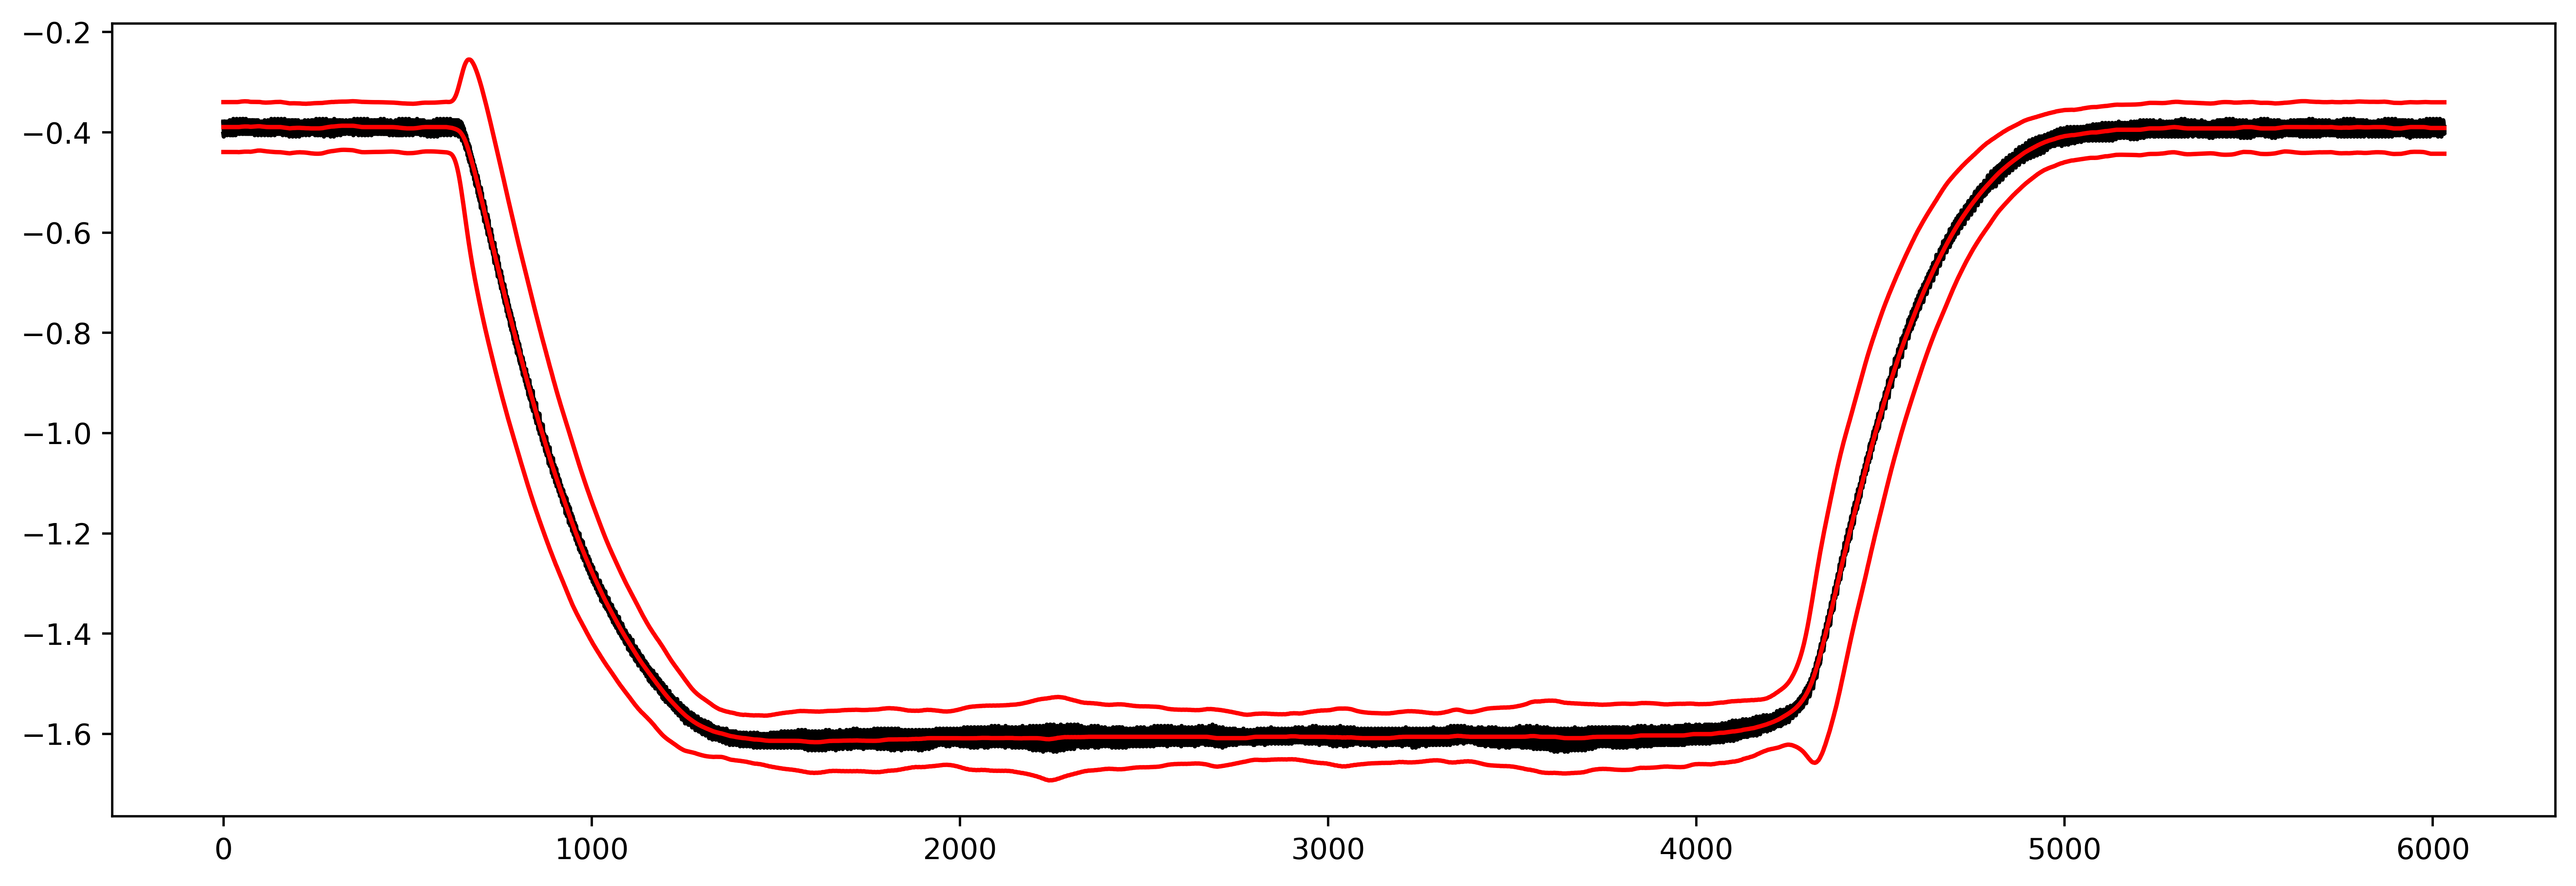

In [6]:
# Get the cluster ts-Data
class_rep, class_len_rep = cluster_representatives.get_cluster_ts(Zuschnitte, lables)

# Test: Calculate Thresholds and Plot for class c and signal a (current spindle: 8 on CMX)
c=0
a=8
median, max_, min_ = cluster_representatives.reference_series(class_rep[c][a])

fig, ax = plt.subplots( figsize=(15, 5), dpi=500)
ax.plot(class_rep[c][a][0],'k')
ax.plot(class_rep[c][a][1],'k')
ax.plot(class_rep[c][a][2],'k')
ax.plot(median[:],'r')
ax.plot(min_[:],'r')
ax.plot(max_[:],'r')


# fig, ax = plt.subplots(2, figsize=(15, 5), dpi=500)
# ax[0].plot(class_rep[c][a][0],'k')
# ax[0].plot(class_rep[c][a][1],'k')
# ax[0].plot(class_rep[c][a][2],'k')
# ax[0].plot(median[:],'r')
# ax[0].plot(min_[:],'r')
# ax[0].plot(max_[:],'r')

# c=0
# a=6
# print(kopfzeile[a])
# median, max_, min_ = cluster_representatives.reference_series(class_rep[c][a])
# ax[1].plot(class_rep[c][a][0],'k')
# ax[1].plot(class_rep[c][a][1],'k')
# ax[1].plot(class_rep[c][a][2],'k')
# ax[1].plot(median[:],'r')
# ax[1].plot(min_[:],'r')
# ax[1].plot(max_[:],'r')
# ax[1].set_ylabel('Current Y-Axis [A]')
# ax[1].set_xlabel('tme [s]')

# fig.savefig(r'C:\Users\stroebel\Desktop\Schwellwert.png')

In [7]:
# Test: train autoencoder for class c and signal a (current spindle: 8 on CMX)
c=0
a=8

train = torch.tensor(class_rep[c][a], dtype=torch.float32)
data_loader = torch.utils.data.DataLoader(dataset=train, batch_size=16, shuffle=True)

model = cluster_representatives.Autoencoder(class_len_rep[c])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

num_epochs = 100   # Training epochs
outputs = []
for epoch in range(num_epochs):
    for input in data_loader:
        recon = model(input)
        loss = criterion(recon, input)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch:{epoch+1}, Loss:{loss.item(): .4f}')
    outputs.append((epoch, input, recon))


C:\Users\stroebel\AppData\Local\Temp\ipykernel_13776\4049036019.py:5: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  train = torch.tensor(class_rep[c][a], dtype=torch.float32)


Epoch:1, Loss: 1.5698
Epoch:2, Loss: 1.5539
Epoch:3, Loss: 1.5283
Epoch:4, Loss: 1.4778
Epoch:5, Loss: 1.4079
Epoch:6, Loss: 1.3179
Epoch:7, Loss: 1.2131
Epoch:8, Loss: 1.0947
Epoch:9, Loss: 0.9694
Epoch:10, Loss: 0.8418
Epoch:11, Loss: 0.7188
Epoch:12, Loss: 0.6027
Epoch:13, Loss: 0.4982
Epoch:14, Loss: 0.4076
Epoch:15, Loss: 0.3309
Epoch:16, Loss: 0.2671
Epoch:17, Loss: 0.2155
Epoch:18, Loss: 0.1749
Epoch:19, Loss: 0.1428
Epoch:20, Loss: 0.1178
Epoch:21, Loss: 0.0986
Epoch:22, Loss: 0.0834
Epoch:23, Loss: 0.0713
Epoch:24, Loss: 0.0616
Epoch:25, Loss: 0.0535
Epoch:26, Loss: 0.0467
Epoch:27, Loss: 0.0409
Epoch:28, Loss: 0.0359
Epoch:29, Loss: 0.0316
Epoch:30, Loss: 0.0277
Epoch:31, Loss: 0.0243
Epoch:32, Loss: 0.0214
Epoch:33, Loss: 0.0188
Epoch:34, Loss: 0.0165
Epoch:35, Loss: 0.0145
Epoch:36, Loss: 0.0128
Epoch:37, Loss: 0.0114
Epoch:38, Loss: 0.0101
Epoch:39, Loss: 0.0090
Epoch:40, Loss: 0.0080
Epoch:41, Loss: 0.0072
Epoch:42, Loss: 0.0065
Epoch:43, Loss: 0.0059
Epoch:44, Loss: 0.00

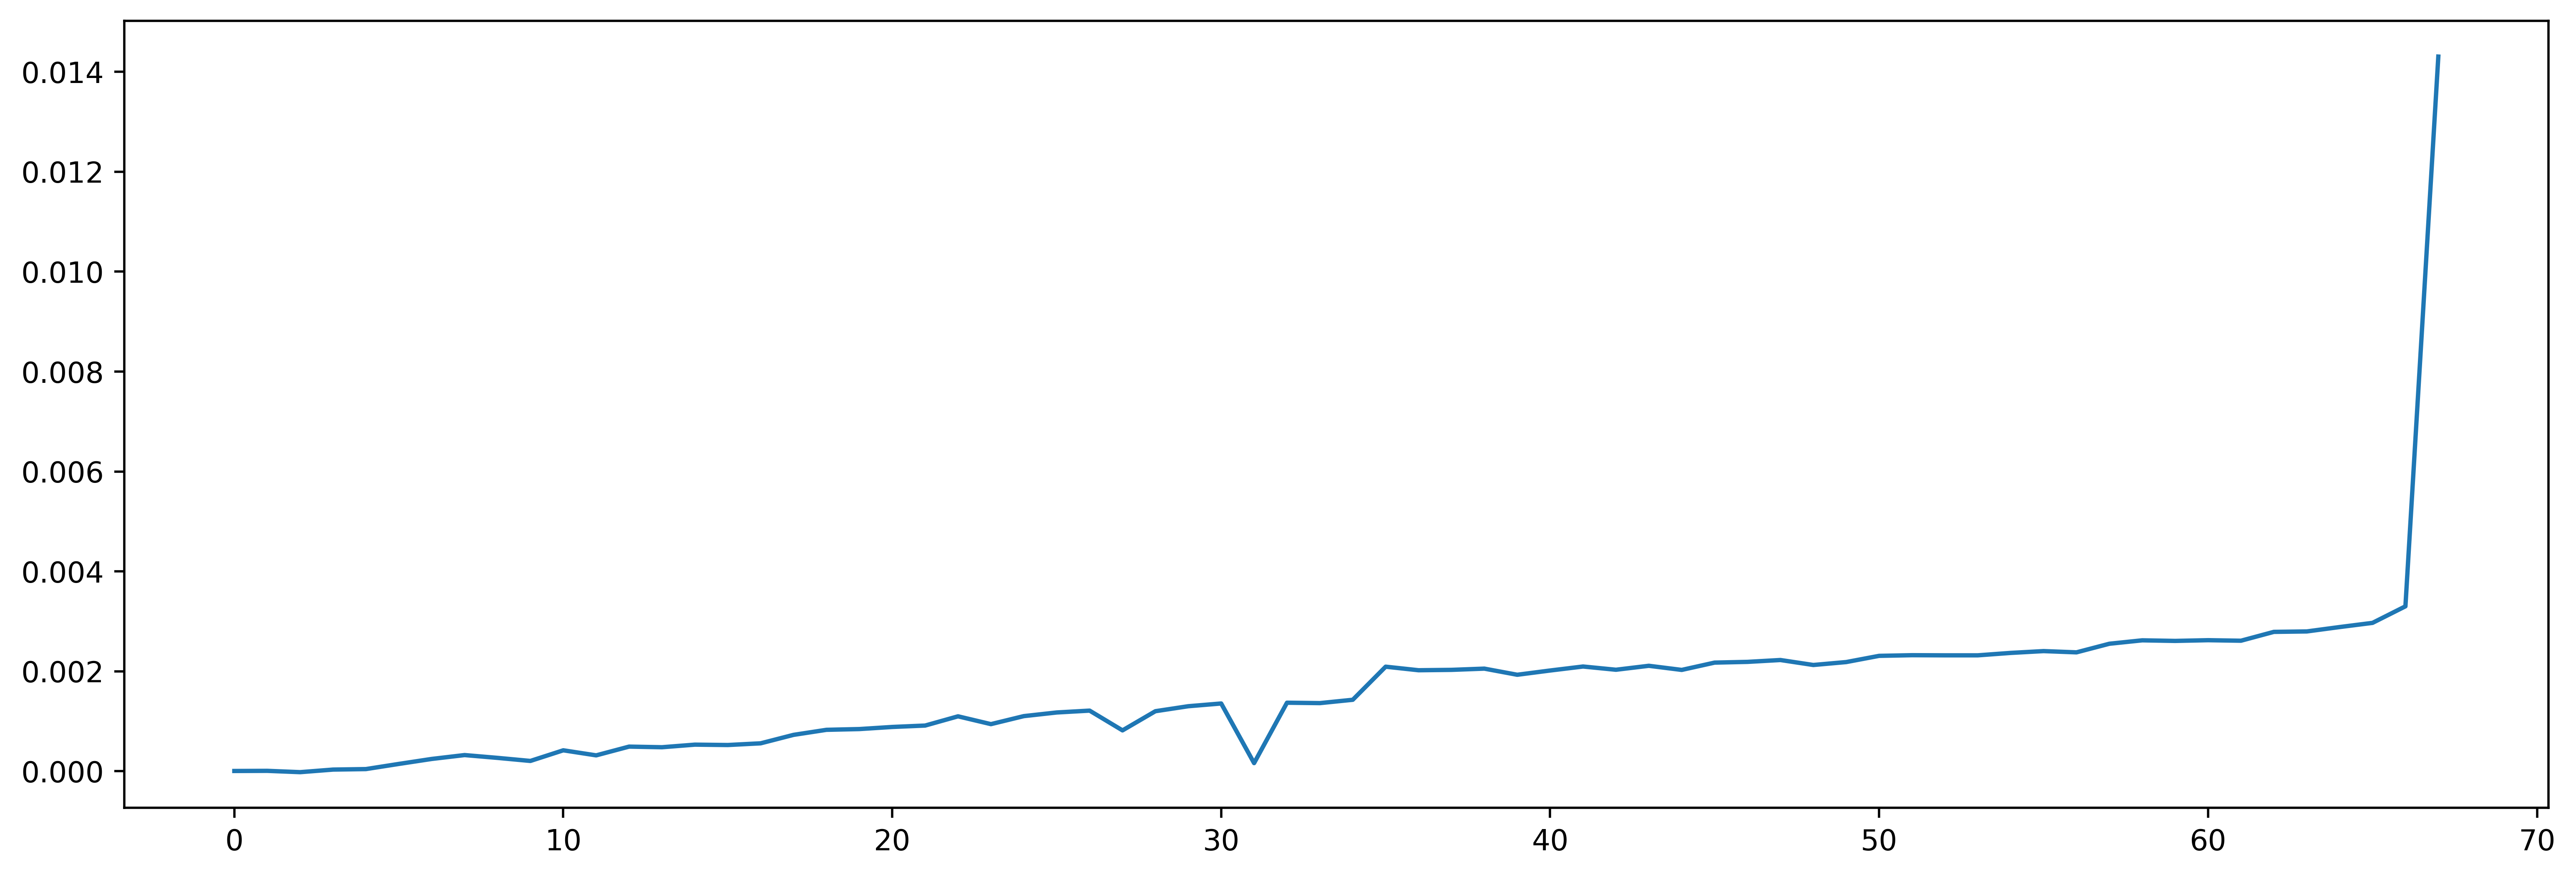

In [8]:
# Test: Calculate the reconsturction error for all timeseries of class c and signal a 

class_rep, class_len_rep = cluster_representatives.get_cluster_ts_inline(Zuschnitte, lables)
df = pd.DataFrame(class_rep[c][a])
rec_error = []   # List for recosntrucion errors

# Colculate the reconstrucion errors as sum
for i in range(len(class_rep[c][a])):
    error = torch.tensor(df.iloc[i,:], dtype=torch.float32)
    rec_error += [sum(model.forward(error)-error).item()/class_len_rep[c]]
    # rec_error += [torch.nn.PairwiseDistance(p=2)(model.forward(error), error).item()]

fig, ax = plt.subplots( figsize=(15, 5), dpi=500)
# ax.set_ylim(0,10)
ax.plot(rec_error) 

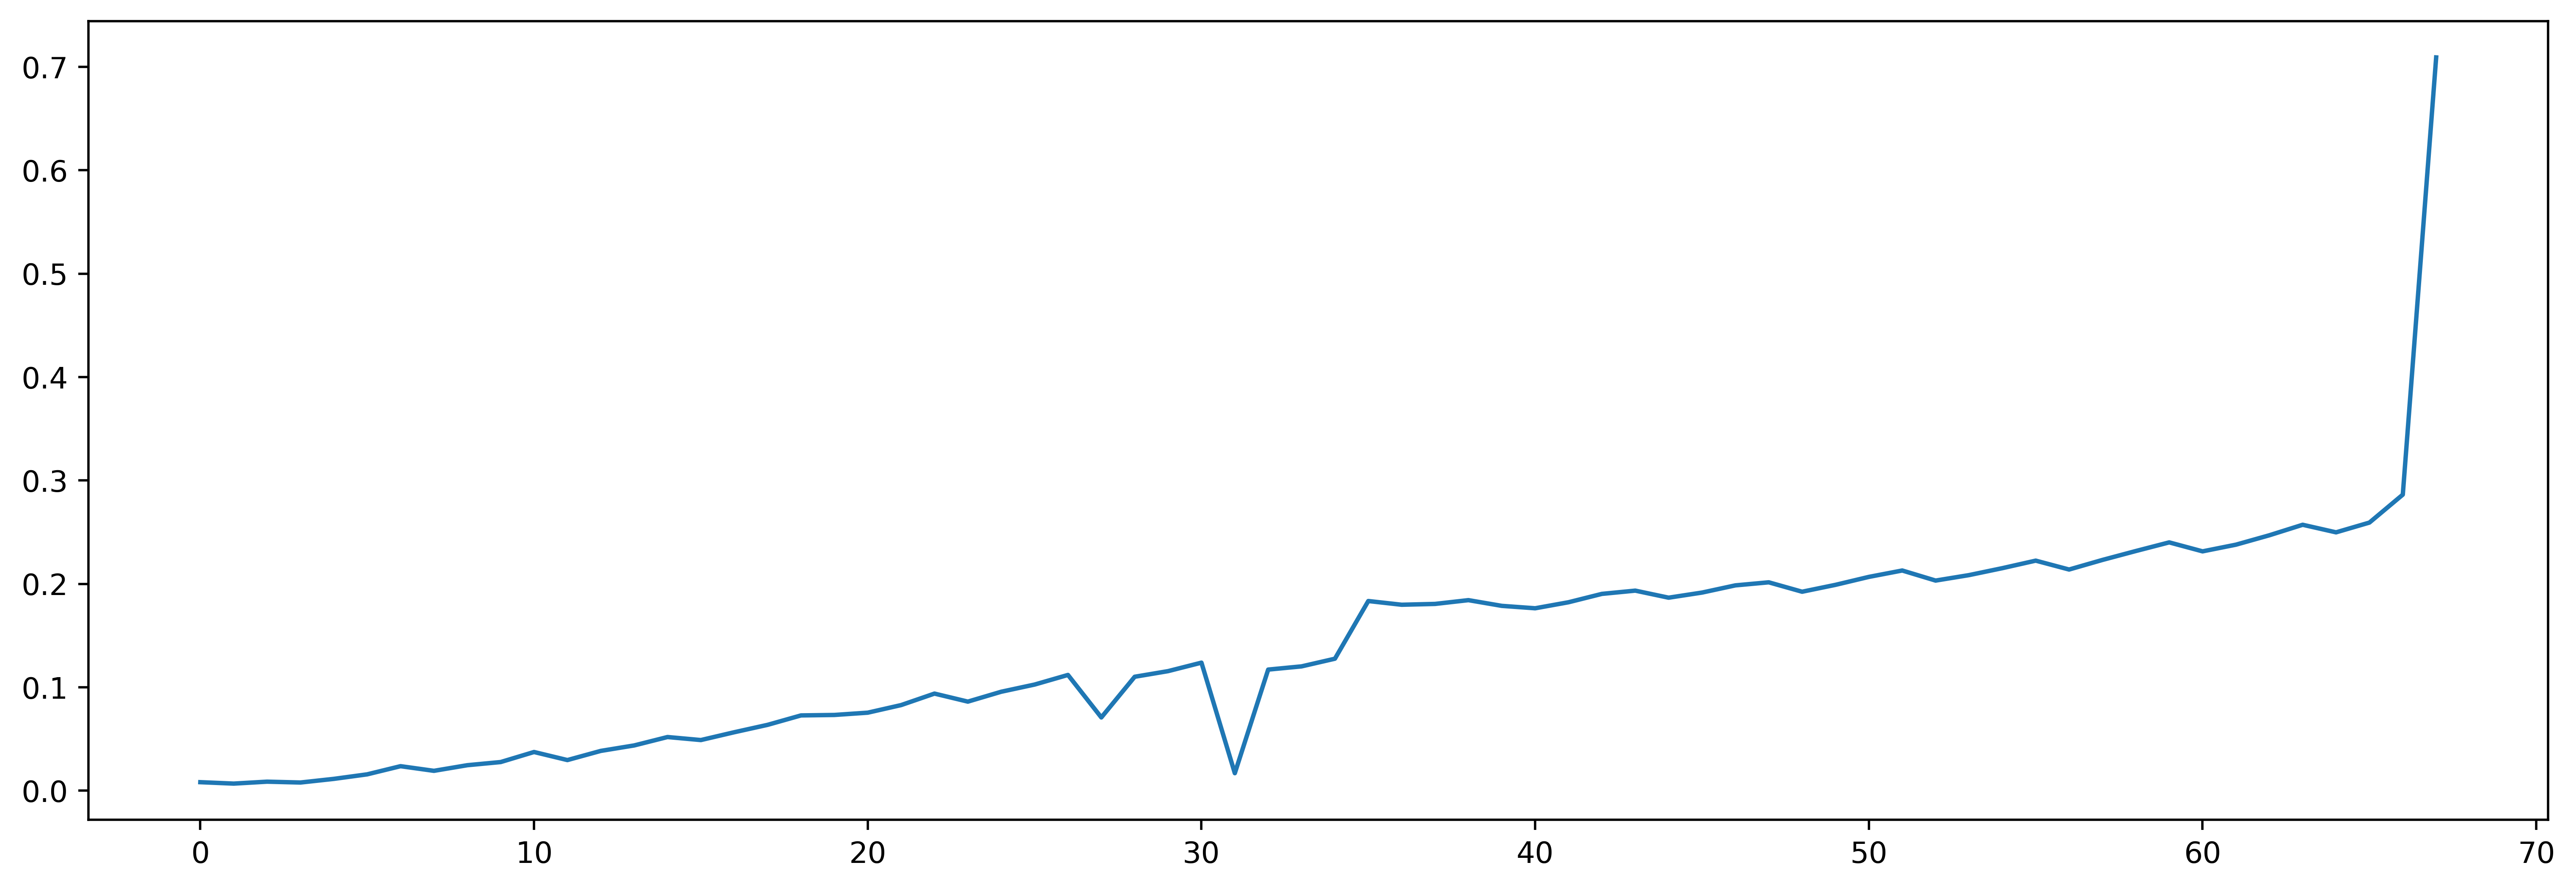

In [9]:
# Test: Calculate the recosntrucion error for all timeseries of class c and signal a 

distance =[]

for i in range(len(class_rep[c][a])):
    distance += [ sum([abs(class_rep[c][a][i][ii]-median[ii])/class_len_rep[c] for ii in range(len(class_rep[c][a][i]))])]
    # distance += [ np.linalg.norm(abs(np.array(class_rep[c][a][i]) - np.array(median)))]   # calculate the euclidean distance

fig, ax = plt.subplots( figsize=(15, 5), dpi=500)
ax.plot(distance)

In [17]:
# Fill matrix with models (Test for learning phase)

class_rep, class_len_rep = cluster_representatives.get_cluster_ts(Zuschnitte, lables)
rep_data = class_rep[c][a]

index = np.linspace(kopfzeile.index('Speed_SP')+1, len(kopfzeile)-1, len(kopfzeile) - kopfzeile.index('Speed_SP')-1).astype(int)
#index = [ i for i in range(len(kopfzeile)) if kopfzeile[i].__contains__('Cur')]
class_nrs = np.unique(lables).tolist()

if class_nrs.__contains__(-1):
    class_nrs.remove(-1)

class_index_models = []   # Matrix for the representative models
index_matrix = []   #   frame-matrix for indices

for class_nr in class_nrs:
    class_index = []
    class_index_vector = []

    for i in index:
        class_index += [cluster_representatives.signal_index(class_rep[class_nr][i], class_len_rep[class_nr])] 
        class_index_vector += [[]]

    class_index_models += [class_index]
    index_matrix += [class_index_vector]



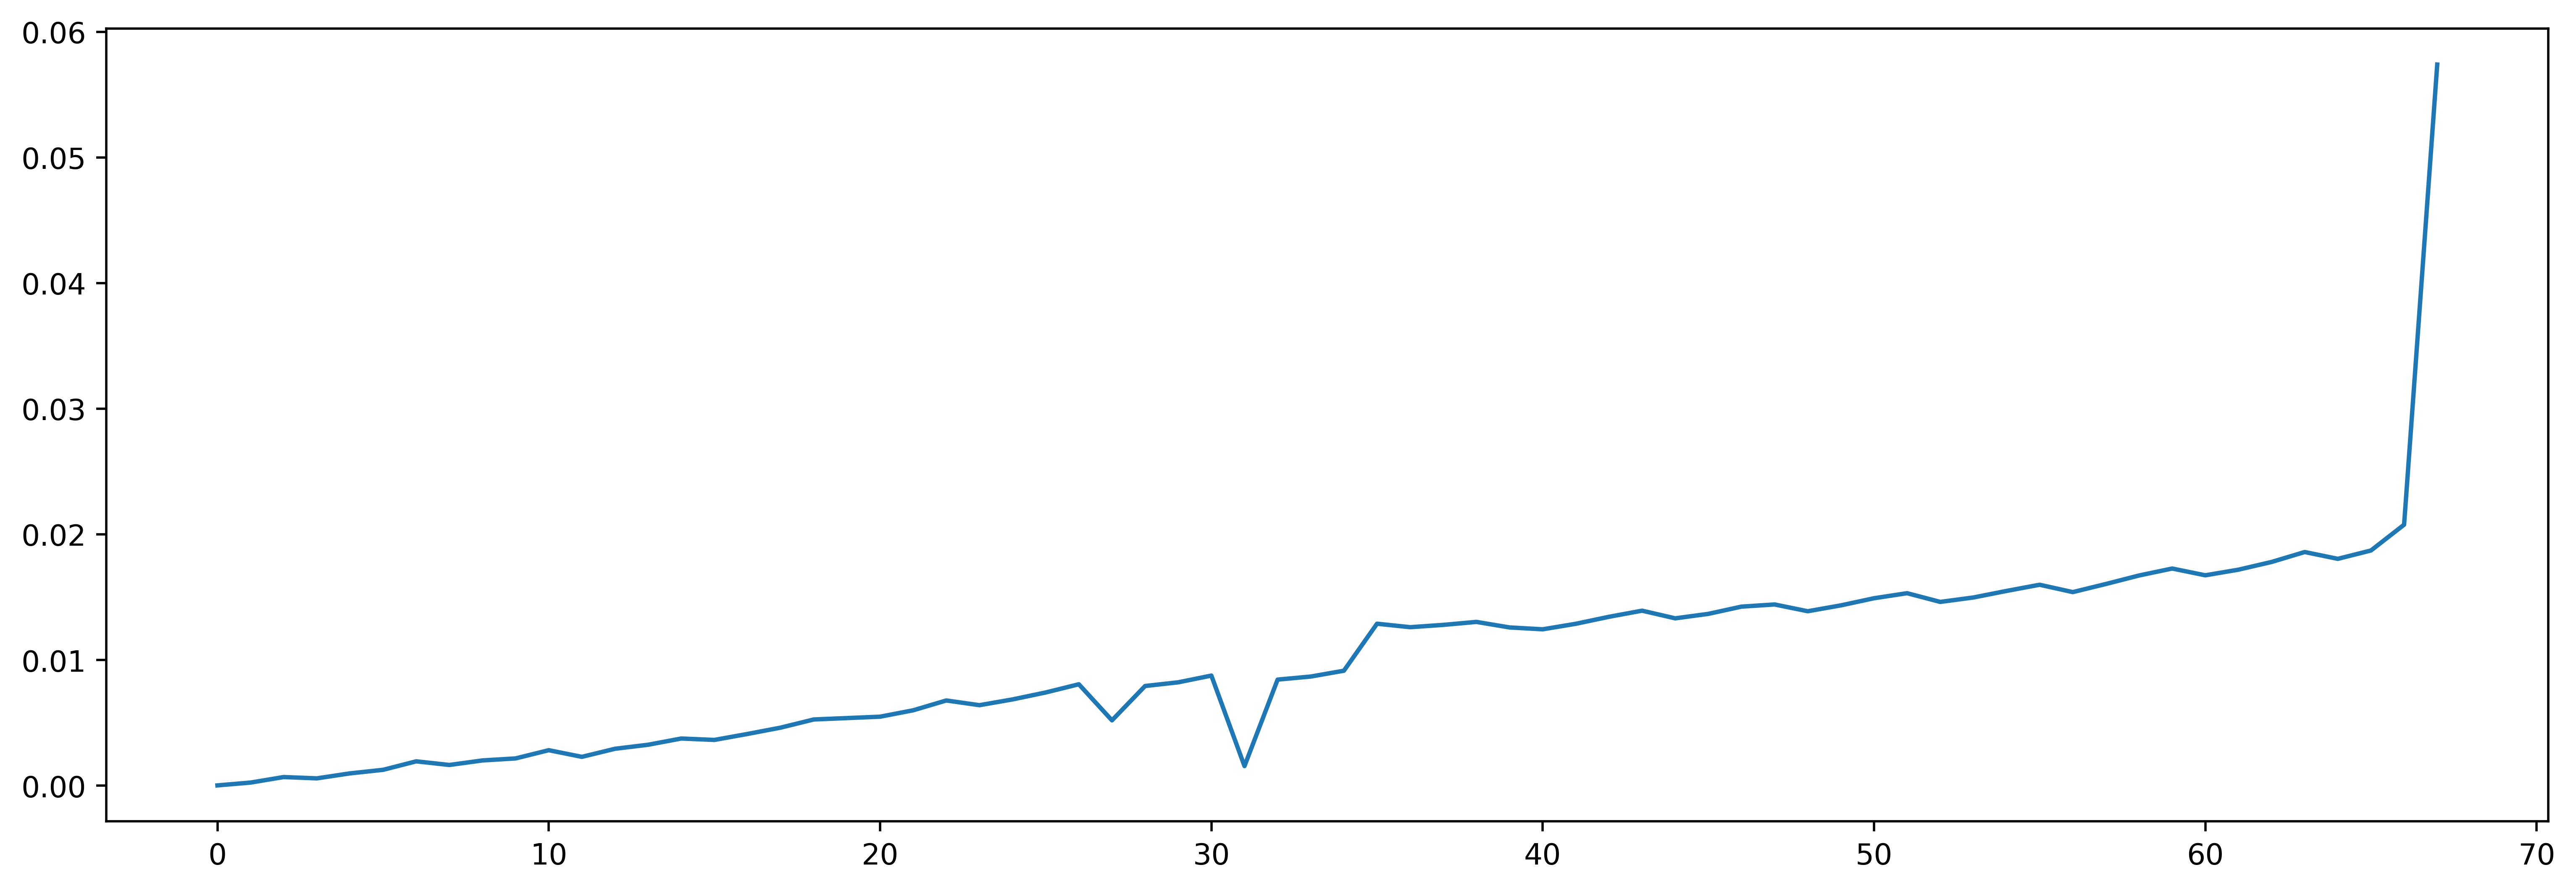

In [18]:
# Fill frame-matrix with indices (Test for inline phase)

class_rep, class_len_rep = cluster_representatives.get_cluster_ts_inline(Zuschnitte, lables)
rep_data = class_rep[c][a]
distance = []
index = [ i for i in range(len(kopfzeile)) if kopfzeile[i].__contains__('Cur')]



inline_lables = get_classes.inline_class(features, class_features, class_std)
class_rep, class_len_rep = cluster_representatives.get_cluster_ts_inline(Zuschnitte, inline_lables)

class_nrs = np.unique(lables).tolist()

if class_nrs.__contains__(-1):
    class_nrs.remove(-1)


index = np.linspace(kopfzeile.index('Speed_SP')+1, len(kopfzeile)-1, len(kopfzeile) - kopfzeile.index('Speed_SP') - 1).astype(int)

        
for i in class_nrs:
    for sig_index in index:
        for nr_ts in range(len(class_rep[i][sig_index])):
        
            index_matrix[i][sig_index - kopfzeile.index('Speed_SP') -1] += [class_index_models[i][sig_index  - kopfzeile.index('Speed_SP') - 1].get_index(class_rep[i][sig_index][nr_ts])]



for i in range(len(class_rep[c][a])):
    distance += [class_index_models[c][a-5].get_index(class_rep[c][a][i])]


fig, ax = plt.subplots( figsize=(15, 5), dpi=500)
ax.plot(distance)

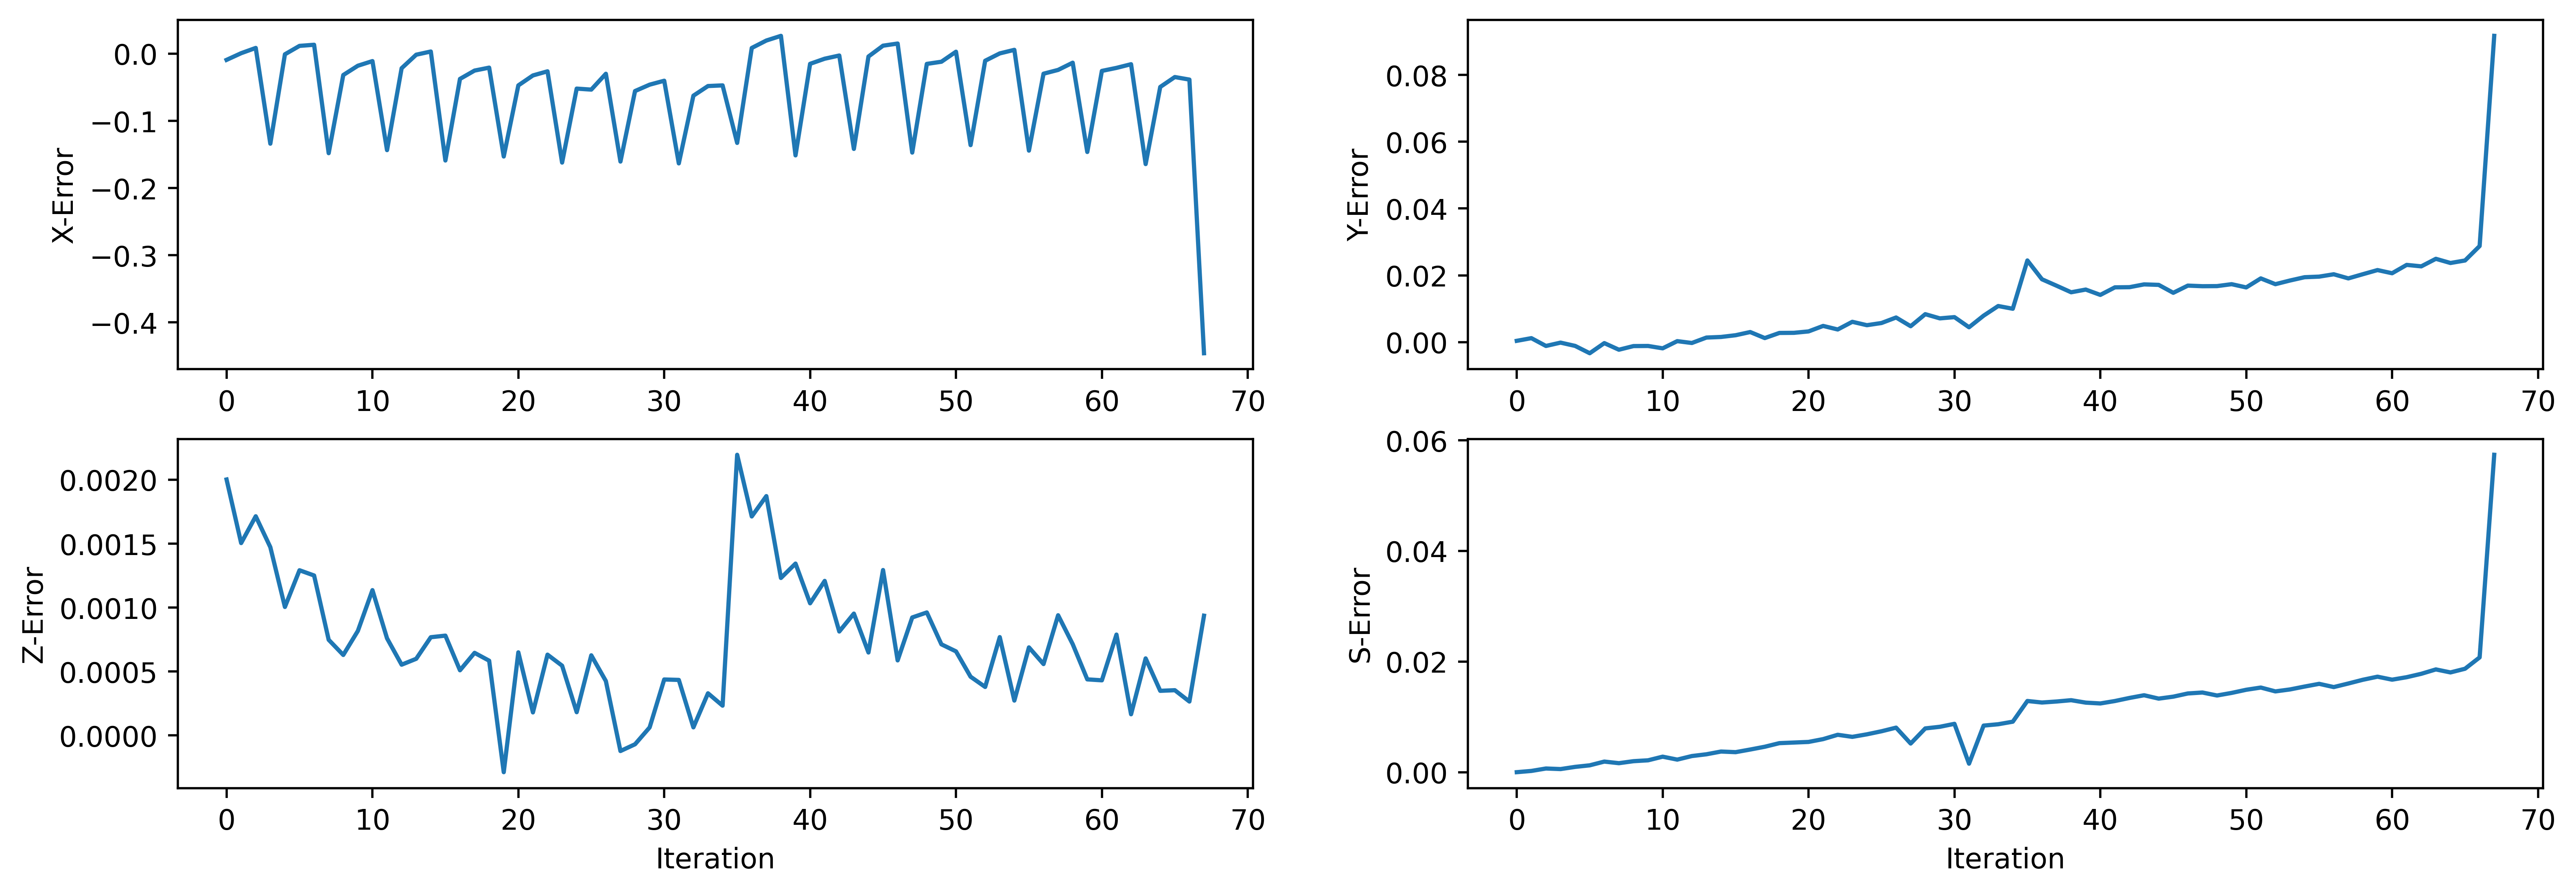

In [21]:
# Plot an index series
# fig, ax = plt.subplots( figsize=(15, 5), dpi=500)
# ax.plot(index_matrix[0][3])


fig, ax = plt.subplots(2,2, figsize=(15, 5), dpi=500)
ax[0,0].plot(index_matrix[0][0])
ax[0,0].set_ylabel('X-Error')

ax[0,1].plot(index_matrix[0][1])
ax[0,1].set_ylabel('Y-Error')

ax[1,0].plot(index_matrix[0][2])
ax[1,0].set_ylabel('Z-Error')
ax[1,0].set_xlabel('Iteration')

ax[1,1].plot(index_matrix[0][3])
ax[1,1].set_ylabel('S-Error')
ax[1,1].set_xlabel('Iteration')


# fig, ax = plt.subplots(2, figsize=(15, 5), dpi=500)
# ax[0].plot(class_rep[c][a][0],'k')
# ax[0].plot(class_rep[c][a][1],'k')
# ax[0].plot(class_rep[c][a][2],'k')
# ax[0].plot(median[:],'r')
# ax[0].plot(min_[:],'r')
# ax[0].plot(max_[:],'r')

# c=0
# a=6
# print(kopfzeile[a])
# median, max_, min_ = cluster_representatives.reference_series(class_rep[c][a])
# ax[1].plot(class_rep[c][a][0],'k')
# ax[1].plot(class_rep[c][a][1],'k')
# ax[1].plot(class_rep[c][a][2],'k')
# ax[1].plot(median[:],'r')
# ax[1].plot(min_[:],'r')
# ax[1].plot(max_[:],'r')
# ax[1].set_ylabel('Current Y-Axis [A]')
# ax[1].set_xlabel('tme [s]')

fig.savefig(r'C:\Users\stroebel\Desktop\Error.png')